In [58]:
import pandas as pd
import pymongo
from datetime import datetime

# Connexion à MongoDB ATTENTION ADAPTER A LA BASE
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["IF29"]
collection = db["tweet"]

# Date maximale pour calculer la durée de vie de l'utilisateur
max_date = datetime(2018, 7, 1)

# Initialiser un dictionnaire pour stocker les données par utilisateur
user_data = {}

# Récupérer les tweets de la base de données et les regrouper par utilisateur
for tweet in collection.find():
    user_id = tweet['user']['id_str']  # Identifiant de l'utilisateur
    hashtags = tweet.get('entities', {}).get('hashtags', [])  # Hashtags dans le tweet
    mentions = tweet.get('entities', {}).get('user_mentions', [])  # Mentions dans le tweet
    links = tweet.get('entities', {}).get('urls', [])  # Liens dans le tweet
    tweet_time = int(tweet['timestamp_ms']) / 1000  # Convertir l'heure du tweet en secondes
    followers = tweet['user']['followers_count']  # Nombre de followers de l'utilisateur
    friends = tweet['user']['friends_count']  # Nombre de friends de l'utilisateur
    created_at = datetime.strptime(tweet['user']['created_at'], '%a %b %d %H:%M:%S +0000 %Y')  # Date de création du compte
    verified = tweet['user']['verified']
    # Ajouter les informations de l'utilisateur s'il n'existe pas encore dans le dictionnaire
    if user_id not in user_data:
        user_data[user_id] = {
            '_id': user_id,
            'nbtweet': 0,
            'total_hashtags': 0,
            'total_mentions': 0,
            'total_links': 0,
            'first_tweet_time': tweet_time,
            'last_tweet_time': tweet_time,
            'followers': followers,
            'friends': friends,
            'verified': verified,
            'created_at': created_at,
            'ratio_friends_followers': 0  # Par défaut
        }

    # Mise à jour des statistiques de l'utilisateur
    user_data[user_id]['nbtweet'] += 1
    user_data[user_id]['total_hashtags'] += len(hashtags)
    user_data[user_id]['total_mentions'] += len(mentions)
    user_data[user_id]['total_links'] += len(links)
    user_data[user_id]['last_tweet_time'] = max(user_data[user_id]['last_tweet_time'], tweet_time)
    user_data[user_id]['first_tweet_time'] = min(user_data[user_id]['first_tweet_time'], tweet_time)

# Calcul de la visibilité et de l'agressivité pour chaque utilisateur
for user_id, data in user_data.items():
    user_lifetime_days = (max_date - data['created_at']).days
    total_hours = user_lifetime_days * 24

    if total_hours > 0:
        data['ftweets'] = data['nbtweet'] / total_hours
        data['ffriends'] = data['friends'] / user_lifetime_days
        data['aggressivity'] = (data['ftweets'] + data['ffriends']) / 350
    else:
        data['ftweets'] = 0
        data['ffriends'] = 0
        data['aggressivity'] = 0

    data['avg_mentions'] = data['total_mentions'] / data['nbtweet']
    data['avg_hashtags'] = data['total_hashtags'] / data['nbtweet']
    data['avg_links'] = data['total_links'] / data['nbtweet']
    data['visibility'] = ((data['avg_hashtags'] * 11.4) + (data['avg_mentions'] * 11.6)) / 140
    data['user_lifetime_days'] = user_lifetime_days

    if data['followers'] != 0:
        data['ratio_friends_followers'] = data['friends'] / data['followers']
    else:
        data['ratio_friends_followers'] = 0

# Convertir le dictionnaire en une liste pour créer le DataFrame
user_data_list = list(user_data.values())

# Créer un DataFrame Pandas à partir des données calculées
df = pd.DataFrame(user_data_list)

# Supprimer les totaux de mentions, de hashtags et de liens du dataset final
df.drop(columns=['total_hashtags', 'total_mentions', 'total_links', 'first_tweet_time', 'last_tweet_time', 'created_at'], inplace=True)

# Afficher le DataFrame
print(df)

,_id,nbtweet,followers,friends,verified,ratio_friends_followers,ftweets,ffriends,aggressivity,avg_mentions,avg_hashtags,avg_links,visibility,user_lifetime_days
0,39084553,1,556,826,False,1.485612,0.000012,0.247454,0.000707,1.00,2.00,0.00,0.245714,3338
1,1564678657,1,918,686,False,0.747277,0.000023,0.376303,0.001075,0.00,0.00,1.00,0.000000,1823
2,967244973824339968,2,34,44,False,1.294118,0.000661,0.349206,0.001000,0.50,0.00,1.00,0.041429,126
3,4872447178,4,2805,3189,False,1.136898,0.000190,3.627986,0.010366,0.75,1.75,0.25,0.204643,879
4,35628099,1,48,407,False,8.479167,0.000012,0.121456,0.000347,2.00,2.00,0.00,0.328571,3351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267463,890034537027207168,1,158,376,False,2.379747,0.000123,1.109145,0.003169,1.00,0.00,0.00,0.082857,339
267464,765835836357222400,1,1034,2130,False,2.059961,0.000061,3.123167,0.008924,2.00,3.00,0.00,0.410000,682
267465,41076311,1,195,198,False,1.015385,0.000013,0.059477,0.000170,0.00,1.00,1.00,0.081429,3329
267466,975133890,1,35,175,False,5.000000,0.000020,0.085784,0.000245,1.00,4.00,0.00,0.408571,2040


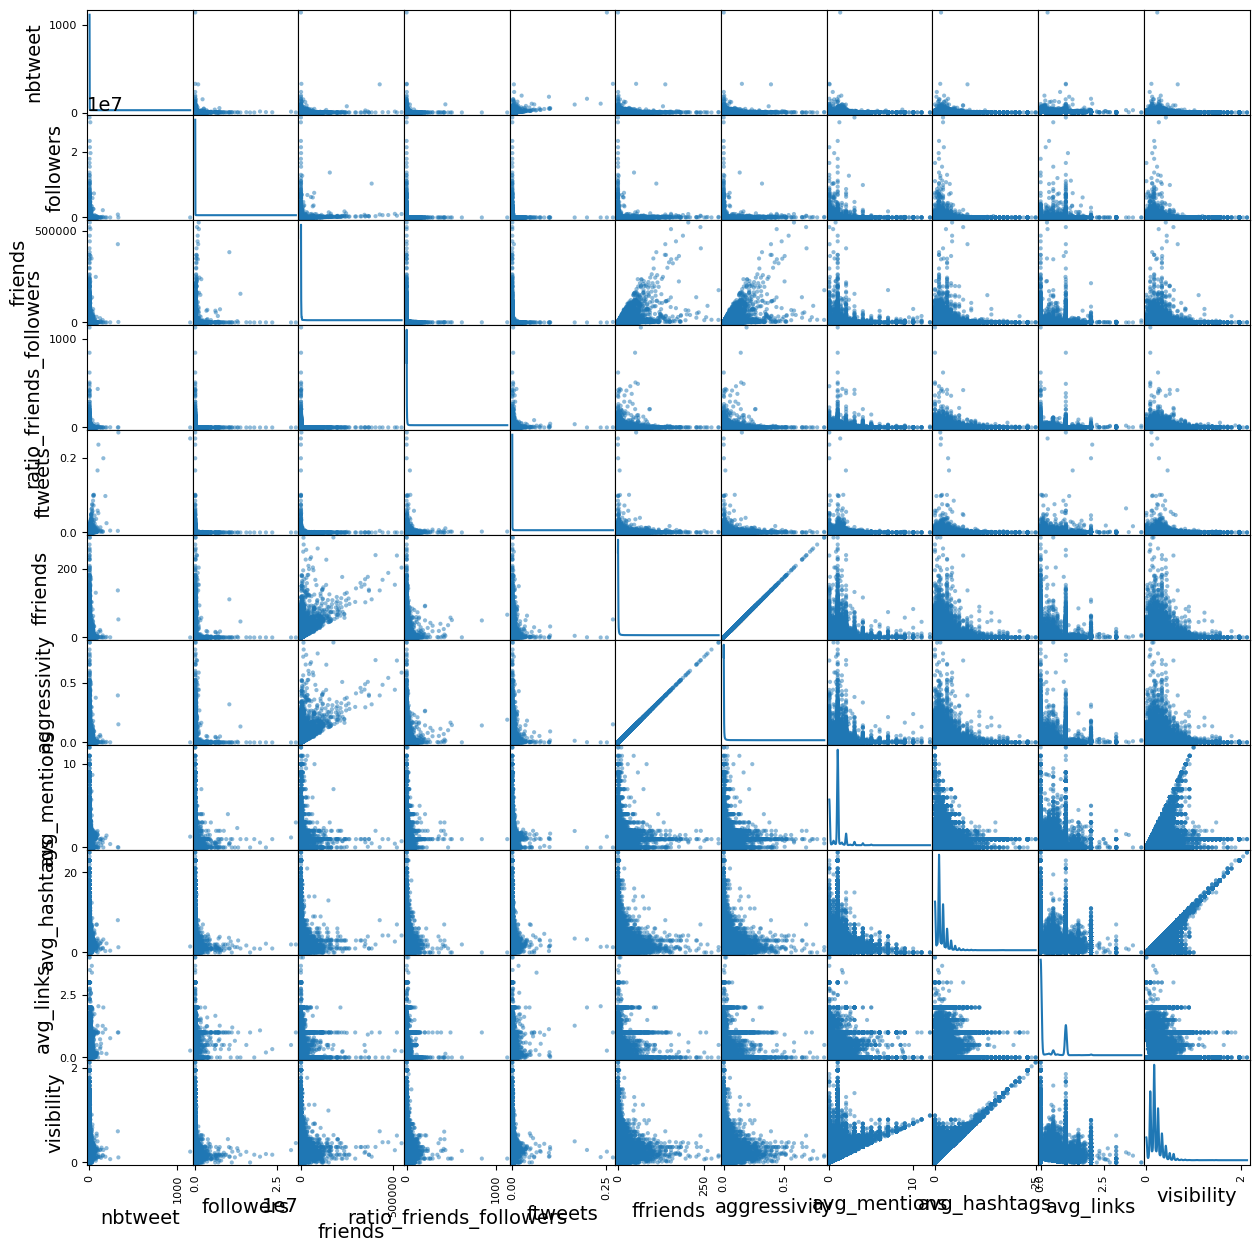

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Assurez-vous d'avoir votre DataFrame df prêt avant d'exécuter ce code

# Affichage de la matrice de dispersion
scatter_matrix = pd.plotting.scatter_matrix(df[['nbtweet', 'followers', 'friends', 'ratio_friends_followers',
                                                 'ftweets', 'ffriends', 'aggressivity', 'avg_mentions',
                                                 'avg_hashtags', 'avg_links', 'visibility']],
                                             figsize=(15, 15), diagonal='kde')
plt.show()



Attributs qui contribuent le plus sur chaque composante principale:
PC1: ['aggressivity', 'ffriends', '_id', 'user_lifetime_days', 'friends']
PC2: ['visibility', 'avg_hashtags', 'avg_mentions', 'avg_links', 'ffriends']


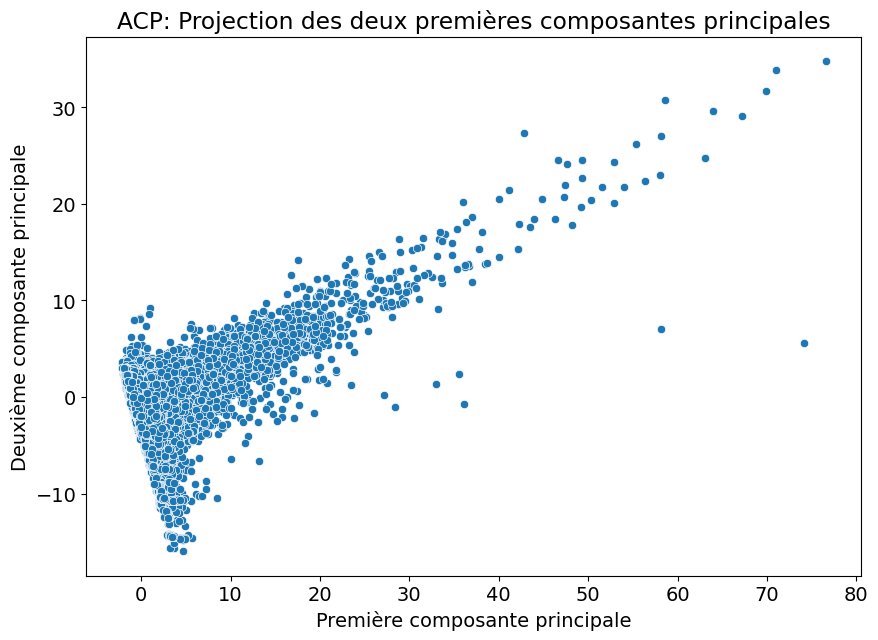

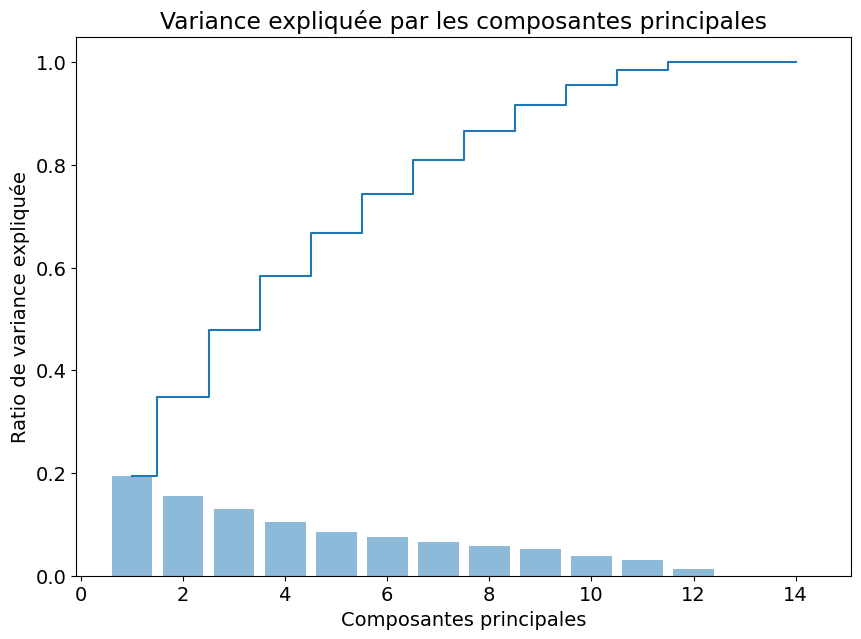

In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


features = df.columns.tolist()
x = df.loc[:, features].values

# Normalisation des données
x = StandardScaler().fit_transform(x)

# Calcul des valeurs propres et des vecteurs propres via PCA
pca = PCA()
principal_components = pca.fit_transform(x)

# la variance expliquée
explained_variance = pca.explained_variance_ratio_

# Nous conservons les composantes principales
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Trouver les attributs qui contribuent le plus sur chaque composante principale
top_attributes = {f'PC{i+1}': [] for i in range(2)}

for i in range(2):
    top_indices = np.argsort(-np.abs(pca.components_[i]))[:5]  # Indices des 5 attributs les plus importants
    top_attributes[f'PC{i+1}'] = df.columns[top_indices]

# Afficher les attributs qui contribuent le plus sur chaque composante principale
print("\nAttributs qui contribuent le plus sur chaque composante principale:")
for comp, attrs in top_attributes.items():
    print(f"{comp}: {list(attrs)}")

# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=principal_df)
plt.title('ACP: Projection des deux premières composantes principales')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.show()

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid')
plt.ylabel('Ratio de variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Variance expliquée par les composantes principales')
plt.show()



Attributs qui contribuent le plus sur chaque composante principale:
PC1: ['ffriends', 'ftweets', 'followers', 'visibility', 'avg_links']
PC2: ['avg_links', 'avg_mentions', 'aggressivity', 'avg_hashtags', 'ftweets']
PC3: ['ratio_friends_followers', '_id', 'visibility', 'followers', 'verified']


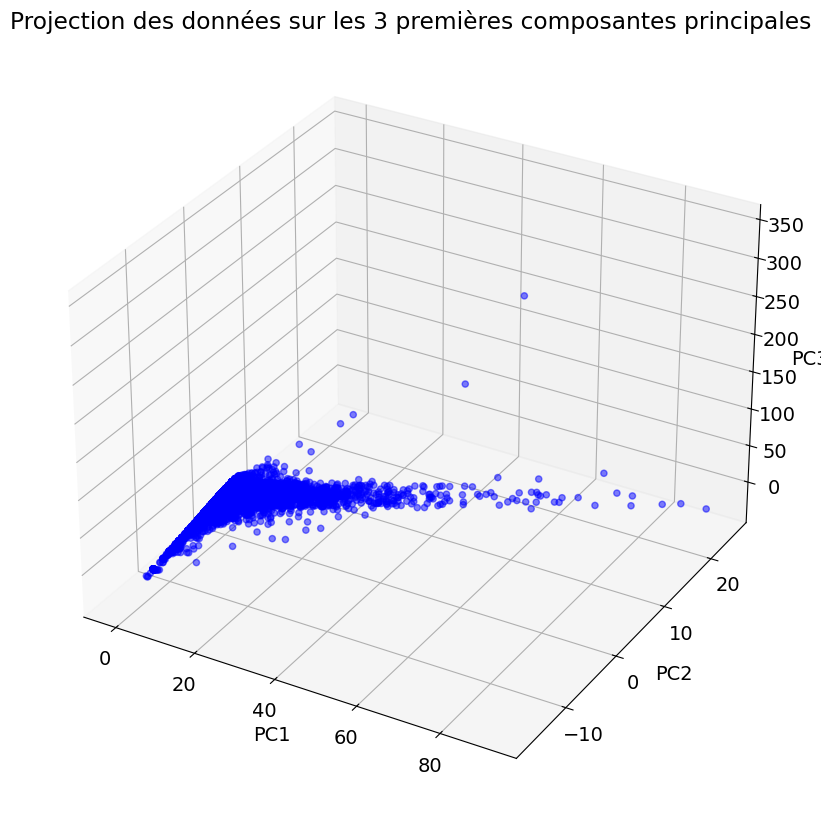

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importer les outils 3D de Matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Sélection des variables à utiliser pour l'ACP
X = df.drop(columns=['_id']) 
features = X.columns.tolist()

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA avec 3 composantes principales
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

# Créer une figure 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Ajouter les données projetées sur les 3 composantes principales
ax.scatter(components[:, 0], components[:, 1], components[:, 2], c='b', marker='o', alpha=0.5)

# Ajouter des étiquettes pour les axes et le titre
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Projection des données sur les 3 premières composantes principales')

# Trouver les attributs qui contribuent le plus sur chaque composante principale
top_attributes = {f'PC{i+1}': [] for i in range(3)}

for i in range(3):
    top_indices = np.argsort(-np.abs(pca.components_[i]))[:5]  # Indices des 5 attributs les plus importants
    top_attributes[f'PC{i+1}'] = df.columns[top_indices]

# Afficher les attributs qui contribuent le plus sur chaque composante principale
print("\nAttributs qui contribuent le plus sur chaque composante principale:")
for comp, attrs in top_attributes.items():
    print(f"{comp}: {list(attrs)}")


plt.rcParams.update({'font.size': 14})
plt.show()


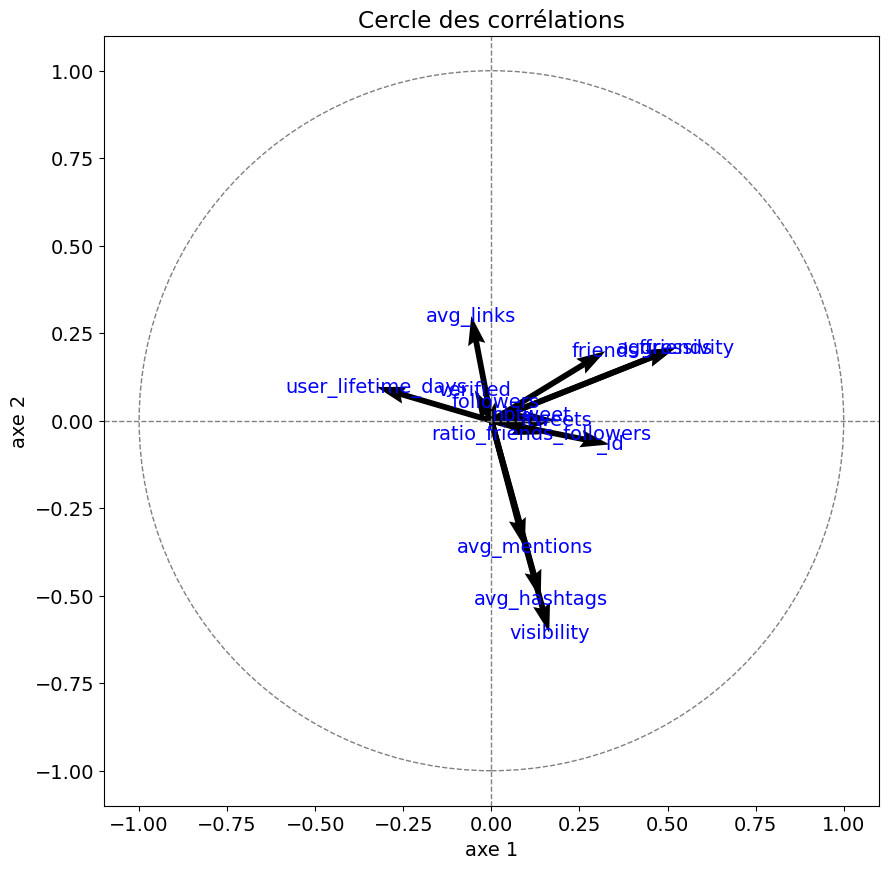


Attributs qui contribuent le plus sur chaque composante principale:
Axe 1: ['aggressivity', 'ffriends', '_id', 'user_lifetime_days', 'friends']
Axe 2: ['visibility', 'avg_hashtags', 'avg_mentions', 'avg_links', 'ffriends']
Attributs qui contribuent le plus sur chaque composante principale :
                             Axe1      Axe2
_id                      0.335436 -0.067820
nbtweet                  0.113322  0.017135
followers                0.011709  0.055208
friends                  0.324044  0.198856
verified                -0.047451  0.086885
ratio_friends_followers  0.141059 -0.039008
ftweets                  0.184672  0.001326
ffriends                 0.523596  0.208820
aggressivity             0.523627  0.208814
avg_mentions             0.094755 -0.361698
avg_hashtags             0.139946 -0.509539
avg_links               -0.057152  0.299207
visibility               0.164281 -0.605784
user_lifetime_days      -0.325714  0.096325


In [62]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

features = df.columns.tolist()
x = df.loc[:, features].values

# Normalisation des données
x = StandardScaler().fit_transform(x)


# Calcul des valeurs propres et des vecteurs propres via PCA
num_components = 2
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_

# Cercle des corrélations
# Calculer les vecteurs propres pour les deux premières composantes
components = pca.components_.T

plt.figure(figsize=(10, 10))
plt.quiver(np.zeros(components.shape[0]), np.zeros(components.shape[0]), 
           components[:, 0], components[:, 1], 
           angles='xy', scale_units='xy', scale=1)

for i, feature in enumerate(features):
    plt.text(components[i, 0], components[i, 1], feature, color='blue', ha='center', va='center')

# Délimiter le cercle unité
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axvline(0, color='grey', linestyle='--', lw=1)
plt.xlabel('axe 1')
plt.ylabel('axe 2')
plt.title('Cercle des corrélations')
plt.rcParams.update({'font.size': 14})
plt.show()

# Trouver les attributs qui contribuent le plus sur chaque composante principale
top_attributes = {f'Axe {i+1}': [] for i in range(num_components)}

for i in range(num_components):
    top_indices = np.argsort(-np.abs(components[:, i]))[:5]  # Indices des 5 attributs les plus importants
    top_attributes[f'Axe {i+1}'] = df.columns[top_indices]

print("\nAttributs qui contribuent le plus sur chaque composante principale:")
for comp, attrs in top_attributes.items():
    print(f"{comp}: {list(attrs)}")


# Afficher les attributs qui contribuent le plus sur chaque composante principale
loading_scores = pd.DataFrame(pca.components_.T, columns=['Axe1', 'Axe2'], index=features)
print("Attributs qui contribuent le plus sur chaque composante principale :")
print(loading_scores)


[ 1.06262093e-17  1.27514511e-18  2.05085839e-17 -1.91271767e-18
  2.82125856e-17 -2.07211081e-17  2.26338258e-17  9.96207120e-19
 -6.34384694e-17  2.61829797e-16  8.46908879e-17 -3.16661036e-17
  2.81594546e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
13
[2.53743955e+00 2.17118826e+00 1.53278777e+00 1.34753170e+00
 1.08820175e+00 1.04972975e+00 8.29661965e-01 7.86102506e-01
 7.16029220e-01 5.11796167e-01 4.29531370e-01 3.95492986e-31
 1.35584104e-31]
[1.95187657e-01 1.67014481e-01 1.17906752e-01 1.03656284e-01
 8.37078268e-02 8.07484424e-02 6.38201512e-02 6.04694236e-02
 5.50791708e-02 3.93689360e-02 3.30408746e-02 3.04225374e-32
 1.04295465e-32]


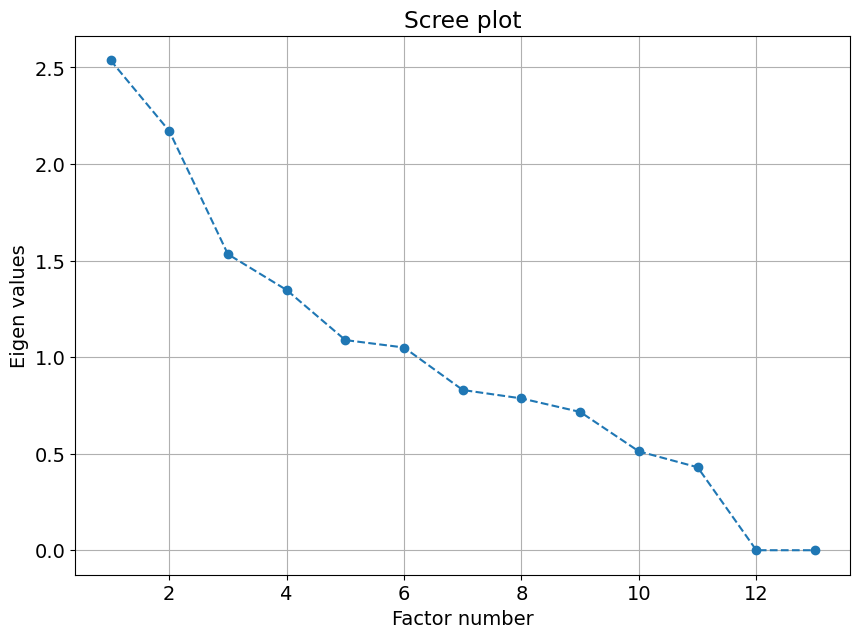

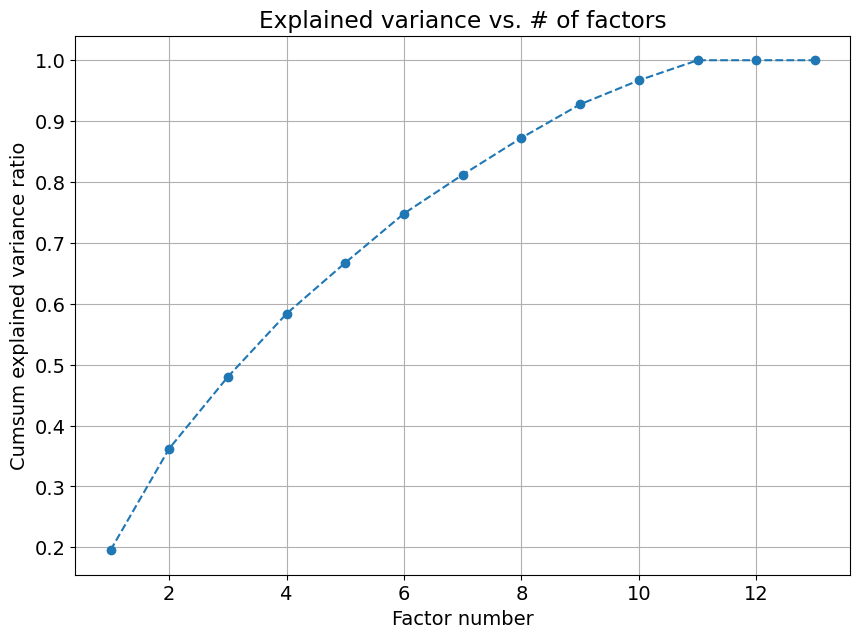

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Préparation des données
X = df.drop(columns=['_id'])  
features = X.columns.tolist()

# Standardisation des données
sc2 = StandardScaler()
Z2 = sc2.fit_transform(X)

# Vérification moyenne et écart-type
print(np.mean(Z2, axis=0))
print(np.std(Z2, axis=0, ddof=0))

# ACP avec scikit-learn
acp2 = PCA(svd_solver='full')
composante_princ2 = acp2.fit_transform(Z2)

# Nombre de composantes calculées
print(acp2.n_components_)

# Valeurs propres
n2 = Z2.shape[0]
eigval2 = acp2.singular_values_**2 / n2
print(eigval2)

# Proportion de variance expliquée
print(acp2.explained_variance_ratio_)

# Scree plot
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, len(eigval2) + 1), eigval2, marker='o', linestyle='--')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid()
plt.show()

# Cumul de variance expliquée
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, len(eigval2) + 1), np.cumsum(acp2.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.grid()
plt.show()


C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\clust

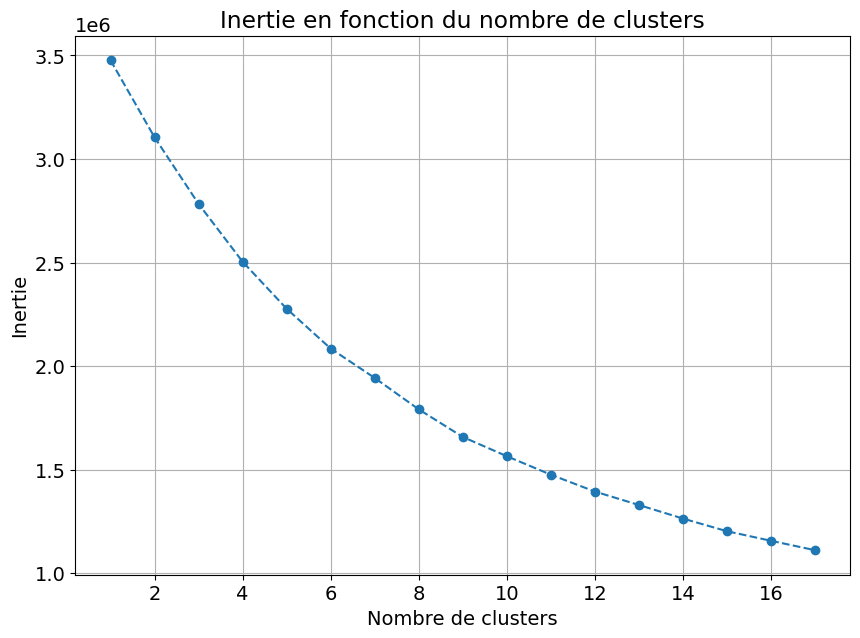

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df.drop(columns=['_id']) 
features = X.columns.tolist()

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialisation des listes pour stocker l'inertie
inertia = []

# Calcul de l'inertie pour différents nombres de clusters de 1 à 10 par exemple
for k in range(1, 18):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracé de la courbe d'inertie
plt.figure(figsize=(10, 7))
plt.plot(range(1, 18), inertia, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Inertie en fonction du nombre de clusters')
plt.grid()
plt.show()


C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marie\anaconda3\Lib\site-packages\sklearn\clust

Silhouette Scores for each k: [0.8810887172965346, 0.5887203448442454, 0.5967002369050274, 0.5146976518519772, 0.5271554175695822, 0.5459900133285236, 0.5450484858708436, 0.5548078006343946, 0.5976226135550403]


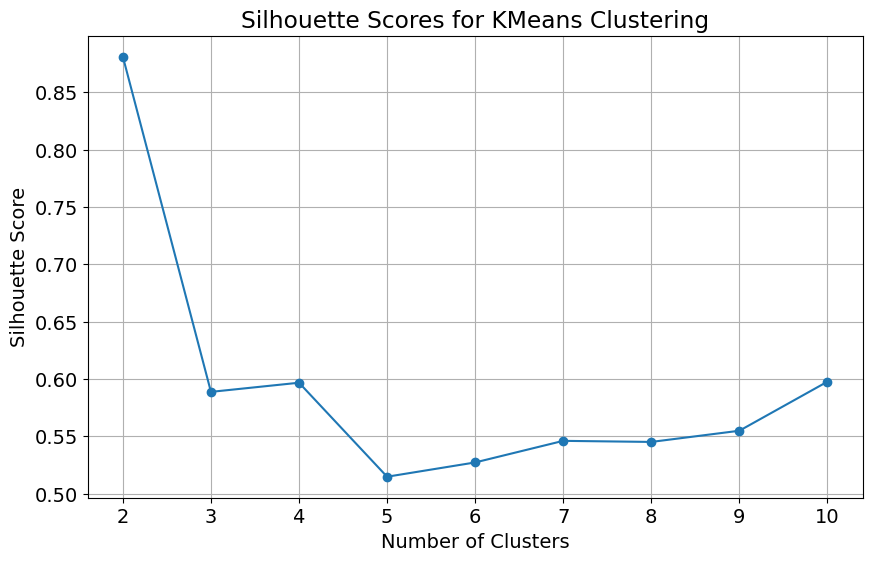

Optimal number of clusters according to the elbow method: 2


C:\Users\marie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


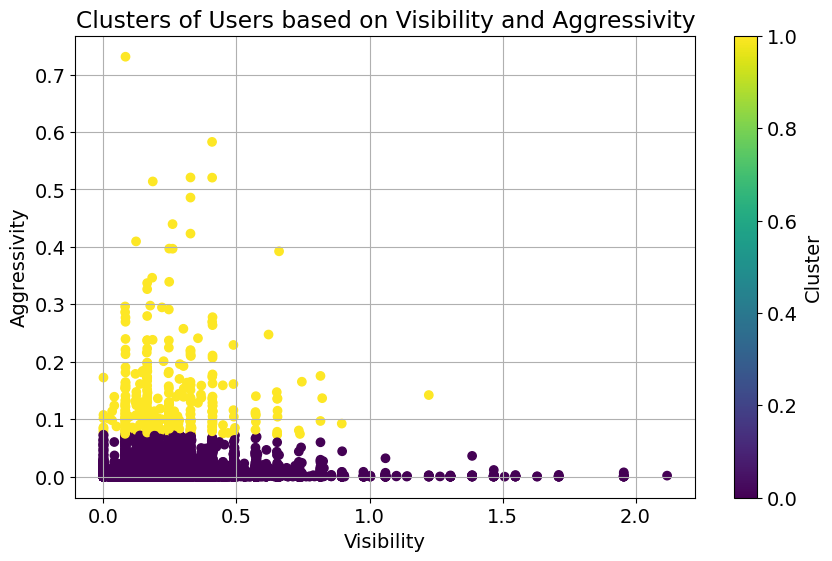

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

# Prendre un échantillon de 50000 lignes pour réduire le temps de calcul
df_sample = df.sample(n=50000, random_state=42)

# Extraire les fonctionnalités visibilité et agressivité
features = ['visibility', 'aggressivity' ]
data = df_sample[features].values

# Normalisation des données
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Calculer les scores de silhouette pour k variant de 2 à 10
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    labels = kmeans.labels_
    silhouette_scores.append(metrics.silhouette_score(data_normalized, labels))

# Afficher les scores de silhouette
print("Silhouette Scores for each k:", silhouette_scores)

# Tracer les scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Scores for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Implémenter la méthode du coude
def find_elbow_point(silhouette_scores):
    deltas = np.diff(silhouette_scores)
    delta_deltas = np.diff(deltas)
    return np.argmax(delta_deltas) + 2  # +2 pour compenser les différences successives

optimal_k = find_elbow_point(silhouette_scores)
print(f"Optimal number of clusters according to the elbow method: {optimal_k}")

# Appliquer KMeans avec le nombre optimal de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(data_normalized)
labels_optimal = kmeans_optimal.labels_

# Ajouter les labels aux données
df_sample['cluster'] = labels_optimal

# Afficher les données avec les clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_sample['visibility'], df_sample['aggressivity'], c=df_sample['cluster'], cmap='viridis')
plt.title("Clusters of Users based on Visibility and Aggressivity")
plt.xlabel("Visibility")
plt.ylabel("Aggressivity")
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()
